# （1）低贡献值阈值敏感性分析

In [50]:
def feature_selection_new(column_names,feature_dict,rela_class,max_values,low_value,high_value):
    for i in range(len(column_names)):
        feature_dict[column_names[i]]['change_range'] = max_values[i]
    Rela_class_copy =copy.deepcopy(rela_class)
    feature_dict_copy =copy.deepcopy(feature_dict) 
    F = column_names
    F_copy = copy.deepcopy(F)
    flag = 0
    num = 0
    for i in range(len(column_names)):
        if feature_dict[column_names[i]]['change_range']>=low_value:
            num+=1
    if (num/len(column_names))>=0.15:#if num>3
        for i in range(len(rela_class)):
            for metric in rela_class[i]:
                if feature_dict[metric]['change_range']>=high_value or feature_dict[metric]['change_range']<=low_value:
                    Rela_class_copy[i].remove(metric)
                    for j in  Rela_class_copy[i]:
                        feature_dict_copy[j]['NOFR'] -=1 
        for metric in F:
            if feature_dict[metric]['change_range']<low_value:
                F_copy.remove(metric)
            elif low_value<feature_dict[metric]['change_range']<high_value and -0.3<feature_dict[metric]['target']<0.3 and feature_dict_copy[metric]['NOFR']>0:
                for i in Rela_class_copy:
                    for j in i:
                        if metric == j:
                            flag == 1
                            change_range = [feature_dict[feature]['change_range'] for feature in i]
                            max_change_range = max(change_range)
                            max_feature = [feature for feature in i if feature_dict[feature]['change_range'] == max_change_range][0]
                            for feature in i:
                                feature_dict_copy[feature]['NOFR'] = 0
                                if feature != max_feature: 
                                    if feature in F_copy:
                                        F_copy.remove(feature)
                            break
                    if flag == 1:
                        break
                flag = 0
    else:
        for i in range(len(rela_class)):
            for metric in rela_class[i]:
                if feature_dict[metric]['change_range']>=low_value:
                    Rela_class_copy[i].remove(metric)
                    for j in  Rela_class_copy[i]:
                        feature_dict_copy[j]['NOFR'] -=1 
        for metric in F:
            if -0.7<feature_dict[metric]['target']<0.7 and feature_dict_copy[metric]['NOFR']>0:
                for i in Rela_class_copy:
                    for j in i:
                        if metric == j:
                            flag == 1
                            change_range = [feature_dict[feature]['change_range'] for feature in i]
                            max_change_range = max(change_range)
                            max_feature = [feature for feature in i if feature_dict[feature]['change_range'] == max_change_range][0]
                            for feature in i:
                                feature_dict_copy[feature]['NOFR'] = 0
                                if feature != max_feature: #
                                    if feature in F_copy:
                                        F_copy.remove(feature)
                            break
                    if flag == 1:
                        break
                flag = 0
    F_remove = [item for item in F if item not in F_copy]
    return F_remove

低贡献值阈值0.007

In [145]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.007
high_value = 0.5
F_remove007 = feature_selection_new(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value)
print(len(F_remove007))
print(F_remove007)

4
['ConvexArea', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3']


In [146]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove007
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 11, 1)


In [147]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [148]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 19s 25ms/step - loss: 1.3795 - accuracy: 0.4920 - val_loss: 0.4999 - val_accuracy: 0.8383
Epoch 2/40
621/621 [==============================] - 14s 23ms/step - loss: 0.5289 - accuracy: 0.8221 - val_loss: 0.3755 - val_accuracy: 0.8723
Epoch 3/40
621/621 [==============================] - 13s 22ms/step - loss: 0.4517 - accuracy: 0.8485 - val_loss: 0.5392 - val_accuracy: 0.8127
Epoch 4/40
621/621 [==============================] - 13s 22ms/step - loss: 0.4696 - accuracy: 0.8369 - val_loss: 0.3621 - val_accuracy: 0.8721
Epoch 5/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4012 - accuracy: 0.8667 - val_loss: 0.5007 - val_accuracy: 0.8121
Epoch 6/40
621/621 [==============================] - 13s 22ms/step - loss: 0.4257 - accuracy: 0.8596 - val_loss: 0.4044 - val_accuracy: 0.8588
Epoch 7/40
621/621 [==============================] - 14s 23ms/step - loss: 0.4254 - accuracy: 0.8539 - val_loss: 0.3704 - val_accuracy:

In [149]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 7ms/step - loss: 0.2222 - accuracy: 0.9198
[0.22219757735729218, 0.9198388457298279]
              precision    recall  f1-score   support

           0    0.97813   0.84939   0.90922       737
           1    1.00000   1.00000   1.00000       686
           2    0.85822   0.95933   0.90596       713
           3    0.89330   0.89575   0.89452       729
           4    0.97173   0.92232   0.94638       708
           5    0.95882   0.94220   0.95044       692
           6    0.80764   0.87571   0.84030       700

    accuracy                        0.91984      4965
   macro avg    0.92398   0.92067   0.92097      4965
weighted avg    0.92383   0.91984   0.92046      4965



低贡献值阈值0.195

In [150]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.195
high_value = 0.5
F_remove195 = feature_selection_new(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value)
print(len(F_remove195))
print(F_remove195)

8
['Perimeter', 'ConvexArea', 'Solidity', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [151]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove195
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 7, 1)


In [152]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [153]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 17s 22ms/step - loss: 1.4850 - accuracy: 0.4491 - val_loss: 1.4223 - val_accuracy: 0.5658
Epoch 2/40
621/621 [==============================] - 12s 20ms/step - loss: 0.6392 - accuracy: 0.7851 - val_loss: 0.5841 - val_accuracy: 0.7805
Epoch 3/40
621/621 [==============================] - 12s 20ms/step - loss: 0.5897 - accuracy: 0.7937 - val_loss: 0.4415 - val_accuracy: 0.8421
Epoch 4/40
621/621 [==============================] - 12s 20ms/step - loss: 0.5508 - accuracy: 0.8035 - val_loss: 0.9377 - val_accuracy: 0.6278
Epoch 5/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4975 - accuracy: 0.8234 - val_loss: 0.8079 - val_accuracy: 0.7114
Epoch 6/40
621/621 [==============================] - 12s 20ms/step - loss: 0.4857 - accuracy: 0.8272 - val_loss: 1.7145 - val_accuracy: 0.4665
Epoch 7/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4367 - accuracy: 0.8432 - val_loss: 0.4378 - val_accuracy:

In [154]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 7ms/step - loss: 0.3206 - accuracy: 0.8769
[0.32060545682907104, 0.8769385814666748]
              precision    recall  f1-score   support

           0    0.82919   0.72456   0.77335       737
           1    0.99854   1.00000   0.99927       686
           2    0.75282   0.84151   0.79470       713
           3    0.94444   0.79287   0.86204       729
           4    0.95960   0.93927   0.94932       708
           5    0.94790   0.94653   0.94722       692
           6    0.75624   0.90857   0.82544       700

    accuracy                        0.87694      4965
   macro avg    0.88411   0.87904   0.87876      4965
weighted avg    0.88340   0.87694   0.87732      4965



低贡献值阈值0.200

In [155]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.2
high_value = 0.5
F_remove2 = feature_selection_new(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value)
print(len(F_remove2))
print(F_remove2)

9
['Perimeter', 'ConvexArea', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [156]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove2
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 6, 1)


In [157]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [158]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 17s 21ms/step - loss: 1.3909 - accuracy: 0.5082 - val_loss: 0.5228 - val_accuracy: 0.8294
Epoch 2/40
621/621 [==============================] - 12s 20ms/step - loss: 0.5245 - accuracy: 0.8212 - val_loss: 0.8061 - val_accuracy: 0.6745
Epoch 3/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4660 - accuracy: 0.8371 - val_loss: 0.4311 - val_accuracy: 0.8455
Epoch 4/40
621/621 [==============================] - 12s 20ms/step - loss: 0.4629 - accuracy: 0.8267 - val_loss: 0.4291 - val_accuracy: 0.8387
Epoch 5/40
621/621 [==============================] - 12s 20ms/step - loss: 0.4415 - accuracy: 0.8401 - val_loss: 0.5993 - val_accuracy: 0.7978
Epoch 6/40
621/621 [==============================] - 12s 20ms/step - loss: 0.4535 - accuracy: 0.8367 - val_loss: 0.5515 - val_accuracy: 0.7782
Epoch 7/40
621/621 [==============================] - 12s 20ms/step - loss: 0.4418 - accuracy: 0.8384 - val_loss: 0.6525 - val_accuracy:

In [159]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 6ms/step - loss: 0.3091 - accuracy: 0.8820
[0.3091318607330322, 0.8819738030433655]
              precision    recall  f1-score   support

           0    0.80512   0.76798   0.78611       737
           1    1.00000   1.00000   1.00000       686
           2    0.77793   0.81066   0.79396       713
           3    0.92227   0.84636   0.88269       729
           4    0.98179   0.91384   0.94660       708
           5    0.94034   0.95665   0.94842       692
           6    0.77778   0.89000   0.83011       700

    accuracy                        0.88197      4965
   macro avg    0.88646   0.88364   0.88398      4965
weighted avg    0.88553   0.88197   0.88268      4965



# (2)高贡献值阈值敏感性分析

In [160]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.1
high_value = 0.18
F_remove18 = feature_selection_new(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value)
print(len(F_remove18))
print(F_remove18)

6
['Perimeter', 'ConvexArea', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [161]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove18
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 9, 1)


In [162]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [163]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 18s 23ms/step - loss: 1.6113 - accuracy: 0.4055 - val_loss: 0.4880 - val_accuracy: 0.8363
Epoch 2/40
621/621 [==============================] - 13s 21ms/step - loss: 0.5266 - accuracy: 0.8166 - val_loss: 0.4078 - val_accuracy: 0.8510
Epoch 3/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4683 - accuracy: 0.8302 - val_loss: 0.4635 - val_accuracy: 0.8403
Epoch 4/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4354 - accuracy: 0.8392 - val_loss: 0.3465 - val_accuracy: 0.8759
Epoch 5/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4254 - accuracy: 0.8450 - val_loss: 0.4091 - val_accuracy: 0.8622
Epoch 6/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4318 - accuracy: 0.8359 - val_loss: 0.4179 - val_accuracy: 0.8359
Epoch 7/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4546 - accuracy: 0.8320 - val_loss: 0.3485 - val_accuracy:

In [164]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 7ms/step - loss: 0.2100 - accuracy: 0.9265
[0.21002039313316345, 0.9264854192733765]
              precision    recall  f1-score   support

           0    0.95328   0.88602   0.91842       737
           1    0.99854   1.00000   0.99927       686
           2    0.87694   0.94951   0.91178       713
           3    0.92826   0.86968   0.89802       729
           4    0.96637   0.93362   0.94971       708
           5    0.94579   0.95809   0.95190       692
           6    0.83134   0.89429   0.86167       700

    accuracy                        0.92649      4965
   macro avg    0.92865   0.92732   0.92725      4965
weighted avg    0.92853   0.92649   0.92677      4965



# (3)相关性阈值敏感性分析

In [165]:
def Feature_correlation_analysis_new(column_names,feature_dict,spearmanr_data,value):
    Feature_correlation_list = []
    correlation_matrix, _ = spearmanr(spearmanr_data, axis=0)
    threshold = value
    correlation_matrix[np.abs(correlation_matrix) < threshold] = np.nan
    plt.figure(figsize=(10, 8))  # 设置图的大小
    mask = np.tri(*correlation_matrix.shape, k=-1)
    correlation_matrix = np.ma.array(correlation_matrix, mask=mask)
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
    plt.xticks(range(len(column_names)), column_names, rotation=45, horizontalalignment='right')
    plt.yticks(range(len(column_names)), column_names)
    # 设置热力图的标题
    plt.title("Spearman秩相关系数矩阵")
    rela_class = []
    count = -1
    rows, cols = np.where(~np.isnan(correlation_matrix))
    for row, col in zip(rows, cols):
        if row != col and correlation_matrix[row, col] != 'masked':
            Feature_correlation_list.append(str(f"Feature {column_names[row]} and Feature {column_names[col]} have correlation: {correlation_matrix[row, col]:.2f}"))
            feature1 = column_names[row]
            feature2 = column_names[col]
            if not rela_class:
                rela_class.append([feature1,feature2])
                continue
            for i in rela_class:
                flag = 0
                count += 1
                if feature1 in i and feature2 not in i :
                    rela_class[count].append(feature2)
                    flag = 1
                    break
                elif feature2 in i and feature1 not in i:
                    rela_class[count].append(feature1)
                    flag = 1
                    break
                elif feature1 in i and feature2 in i:
                    flag = 1
                    break
            if flag == 0:
                rela_class.append([feature1, feature2])
            flag = 0
            count = -1
    result = []
    for sublist in rela_class:
        merged = False
        for existing in result:
            if any(item in existing for item in sublist):
                existing.extend(item for item in sublist if item not in existing)
                merged = True
                break
        if not merged:
            result.append(sublist)
    rela_class = result
    for i in rela_class:
        for j in i:
            if j in feature_dict:
                feature_dict[j]['correlation'] = True
    F = column_names
    F_copy = copy.deepcopy(F)
    for i in F:
        if feature_dict[i]['correlation'] is False:
            feature_dict[i]['NOFR'] = 0
        else:
            for j in rela_class:
                for metric in j:
                    if metric == i:
                         feature_dict[i]['NOFR'] = len(j)-1    
    return rela_class,feature_dict,Feature_correlation_list

In [166]:
def feature_selection_new2(column_names,feature_dict,rela_class,max_values,low_value,high_value,rela,high_rela):
    for i in range(len(column_names)):
        feature_dict[column_names[i]]['change_range'] = max_values[i]
    Rela_class_copy =copy.deepcopy(rela_class)
    feature_dict_copy =copy.deepcopy(feature_dict) 
    F = column_names
    F_copy = copy.deepcopy(F)
    flag = 0
    num = 0
    for i in range(len(column_names)):
        if feature_dict[column_names[i]]['change_range']>=low_value:
            num+=1
    if (num/len(column_names))>=0.15:#if num>3
        for i in range(len(rela_class)):
            for metric in rela_class[i]:
                if feature_dict[metric]['change_range']>=high_value or feature_dict[metric]['change_range']<=low_value:
                    Rela_class_copy[i].remove(metric)
                    for j in  Rela_class_copy[i]:
                        feature_dict_copy[j]['NOFR'] -=1 
        for metric in F:
            if feature_dict[metric]['change_range']<low_value:
                F_copy.remove(metric)
            elif low_value<feature_dict[metric]['change_range']<high_value and -rela<feature_dict[metric]['target']<rela and feature_dict_copy[metric]['NOFR']>0:
                for i in Rela_class_copy:
                    for j in i:
                        if metric == j:
                            flag == 1
                            change_range = [feature_dict[feature]['change_range'] for feature in i]
                            max_change_range = max(change_range)
                            max_feature = [feature for feature in i if feature_dict[feature]['change_range'] == max_change_range][0]
                            for feature in i:
                                feature_dict_copy[feature]['NOFR'] = 0
                                if feature != max_feature: 
                                    if feature in F_copy:
                                        F_copy.remove(feature)
                            break
                    if flag == 1:
                        break
                flag = 0
    else:
        for i in range(len(rela_class)):
            for metric in rela_class[i]:
                if feature_dict[metric]['change_range']>=low_value:
                    Rela_class_copy[i].remove(metric)
                    for j in  Rela_class_copy[i]:
                        feature_dict_copy[j]['NOFR'] -=1 
        for metric in F:
            if -high_rela < feature_dict[metric]['target']< high_rela and feature_dict_copy[metric]['NOFR']>0:
                for i in Rela_class_copy:
                    for j in i:
                        if metric == j:
                            flag == 1
                            change_range = [feature_dict[feature]['change_range'] for feature in i]
                            max_change_range = max(change_range)
                            max_feature = [feature for feature in i if feature_dict[feature]['change_range'] == max_change_range][0]
                            for feature in i:
                                feature_dict_copy[feature]['NOFR'] = 0
                                if feature != max_feature: #
                                    if feature in F_copy:
                                        F_copy.remove(feature)
                            break
                    if flag == 1:
                        break
                flag = 0
    F_remove = [item for item in F if item not in F_copy]
    return F_remove

D:\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


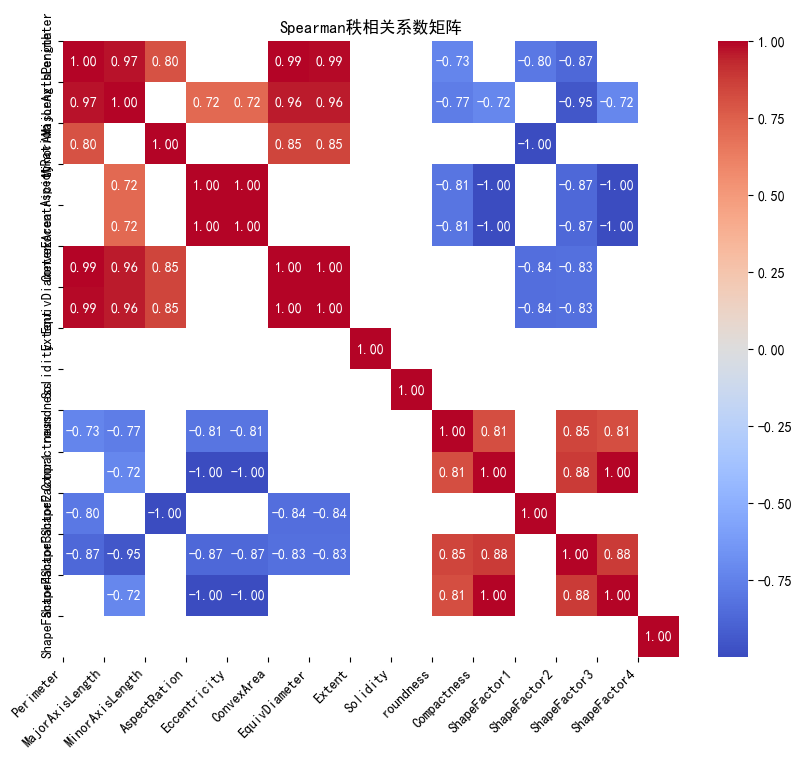

In [185]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
column_names = df.columns[1:-1].tolist()
feature_dict = {}
spearmanr_data = df.iloc[:,1:-1]
feature_dict = set_feature_dict(column_names,feature_dict)
value = 0.7
rela_class,feature_dict,feature_correlation_list = Feature_correlation_analysis_new(column_names,feature_dict,spearmanr_data,value)
target_variable = df['Class']
column_names = df.columns[1:-1]
feature_dict,target_variable_list = target_correlation_analysis(feature_dict,target_variable,column_names)

In [186]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.1
high_value = 0.5
rela = 0.1
value = 0.7
F_remove_rela1 = feature_selection_new2(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value,rela,value)
print(len(F_remove_rela1))
print(F_remove_rela1)

6
['Perimeter', 'ConvexArea', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [187]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove_rela1
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 9, 1)


In [188]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [189]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 18s 23ms/step - loss: 1.4166 - accuracy: 0.4813 - val_loss: 0.4417 - val_accuracy: 0.8356
Epoch 2/40
621/621 [==============================] - 13s 21ms/step - loss: 0.5377 - accuracy: 0.8182 - val_loss: 0.4602 - val_accuracy: 0.8284
Epoch 3/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4853 - accuracy: 0.8252 - val_loss: 0.4420 - val_accuracy: 0.8427
Epoch 4/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4492 - accuracy: 0.8320 - val_loss: 0.4650 - val_accuracy: 0.8393
Epoch 5/40
621/621 [==============================] - 14s 22ms/step - loss: 0.3913 - accuracy: 0.8572 - val_loss: 0.3558 - val_accuracy: 0.8691
Epoch 6/40
621/621 [==============================] - 14s 22ms/step - loss: 0.3628 - accuracy: 0.8697 - val_loss: 0.3625 - val_accuracy: 0.8606
Epoch 7/40
621/621 [==============================] - 13s 21ms/step - loss: 0.3781 - accuracy: 0.8616 - val_loss: 0.3360 - val_accuracy:

In [190]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 2s 10ms/step - loss: 0.2143 - accuracy: 0.9235
[0.21432846784591675, 0.9234642386436462]
              precision    recall  f1-score   support

           0    0.94236   0.88738   0.91405       737
           1    1.00000   1.00000   1.00000       686
           2    0.88697   0.93548   0.91058       713
           3    0.94819   0.82853   0.88433       729
           4    0.95857   0.94774   0.95312       708
           5    0.94452   0.95954   0.95197       692
           6    0.80580   0.91286   0.85599       700

    accuracy                        0.92346      4965
   macro avg    0.92663   0.92450   0.92429      4965
weighted avg    0.92659   0.92346   0.92374      4965



# (4)强相关性阈值敏感性分析

阈值0.6

D:\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


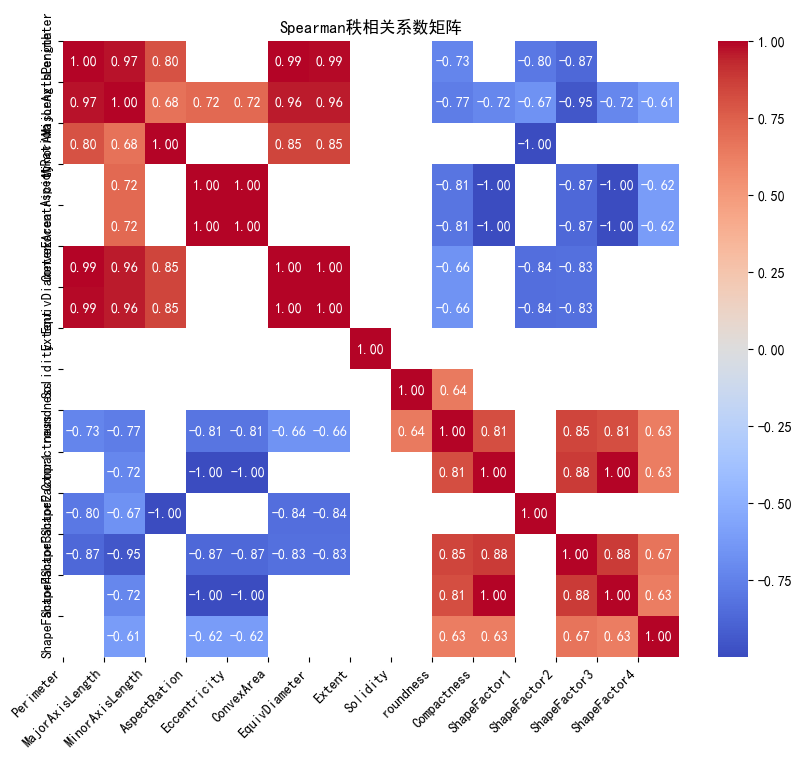

In [173]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
column_names = df.columns[1:-1].tolist()
feature_dict = {}
spearmanr_data = df.iloc[:,1:-1]
feature_dict = set_feature_dict(column_names,feature_dict)
value = 0.6
rela_class,feature_dict,feature_correlation_list = Feature_correlation_analysis_new(column_names,feature_dict,spearmanr_data,value)
target_variable = df['Class']
column_names = df.columns[1:-1]
feature_dict,target_variable_list = target_correlation_analysis(feature_dict,target_variable,column_names)

In [174]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.1
high_value = 0.5
rela = 0.3
value = 0.6
F_remove_high_rela6 = feature_selection_new2(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value,rela,value)
print(len(F_remove_high_rela6))
print(F_remove_high_rela6)

8
['Perimeter', 'ConvexArea', 'Solidity', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [175]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove_high_rela6
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 7, 1)


In [176]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [177]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 17s 22ms/step - loss: 1.3010 - accuracy: 0.5374 - val_loss: 0.4672 - val_accuracy: 0.8512
Epoch 2/40
621/621 [==============================] - 13s 20ms/step - loss: 0.5326 - accuracy: 0.8134 - val_loss: 0.4088 - val_accuracy: 0.8586
Epoch 3/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4640 - accuracy: 0.8370 - val_loss: 0.3621 - val_accuracy: 0.8705
Epoch 4/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4491 - accuracy: 0.8336 - val_loss: 0.4075 - val_accuracy: 0.8475
Epoch 5/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4312 - accuracy: 0.8445 - val_loss: 0.6806 - val_accuracy: 0.7267
Epoch 6/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4338 - accuracy: 0.8441 - val_loss: 0.3352 - val_accuracy: 0.8723
Epoch 7/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4298 - accuracy: 0.8401 - val_loss: 0.4484 - val_accuracy:

In [178]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 7ms/step - loss: 0.3039 - accuracy: 0.8806
[0.3038873076438904, 0.8805639743804932]
              precision    recall  f1-score   support

           0    0.83548   0.70285   0.76345       737
           1    1.00000   1.00000   1.00000       686
           2    0.74662   0.85133   0.79554       713
           3    0.90544   0.86694   0.88577       729
           4    0.96637   0.93362   0.94971       708
           5    0.94429   0.95520   0.94971       692
           6    0.79450   0.86714   0.82923       700

    accuracy                        0.88056      4965
   macro avg    0.88467   0.88244   0.88192      4965
weighted avg    0.88378   0.88056   0.88050      4965



阈值0.9

D:\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


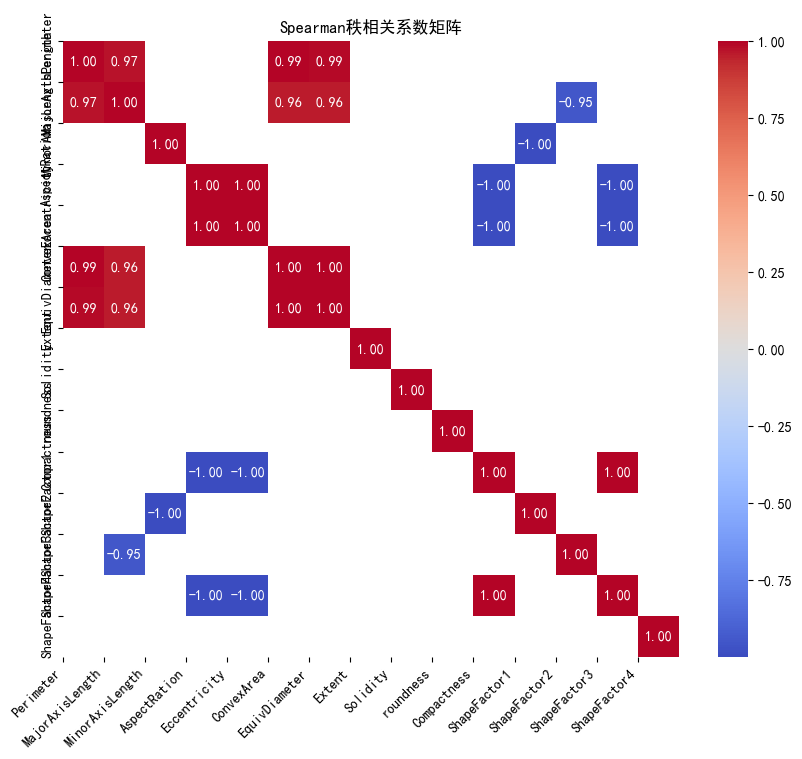

In [179]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
column_names = df.columns[1:-1].tolist()
feature_dict = {}
spearmanr_data = df.iloc[:,1:-1]
feature_dict = set_feature_dict(column_names,feature_dict)
value = 0.9
rela_class,feature_dict,feature_correlation_list = Feature_correlation_analysis_new(column_names,feature_dict,spearmanr_data,value)
target_variable = df['Class']
column_names = df.columns[1:-1]
feature_dict,target_variable_list = target_correlation_analysis(feature_dict,target_variable,column_names)

In [180]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.1
high_value = 0.5
rela = 0.3
value = 0.9
F_remove_high_rela6 = feature_selection_new2(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value,rela,value)
print(len(F_remove_high_rela6))
print(F_remove_high_rela6)

6
['Perimeter', 'ConvexArea', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [181]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove_high_rela6
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 9, 1)


In [182]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [183]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 18s 23ms/step - loss: 1.4177 - accuracy: 0.4842 - val_loss: 0.4877 - val_accuracy: 0.8403
Epoch 2/40
621/621 [==============================] - 13s 21ms/step - loss: 0.5317 - accuracy: 0.8188 - val_loss: 0.5063 - val_accuracy: 0.8087
Epoch 3/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4828 - accuracy: 0.8274 - val_loss: 0.3725 - val_accuracy: 0.8703
Epoch 4/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4570 - accuracy: 0.8333 - val_loss: 0.3799 - val_accuracy: 0.8620
Epoch 5/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4532 - accuracy: 0.8315 - val_loss: 0.3730 - val_accuracy: 0.8640
Epoch 6/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4199 - accuracy: 0.8493 - val_loss: 0.4986 - val_accuracy: 0.8153
Epoch 7/40
621/621 [==============================] - 13s 21ms/step - loss: 0.3796 - accuracy: 0.8605 - val_loss: 0.3844 - val_accuracy:

In [184]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 7ms/step - loss: 0.2119 - accuracy: 0.9263
[0.21185874938964844, 0.9262840151786804]
              precision    recall  f1-score   support

           0    0.94323   0.87924   0.91011       737
           1    1.00000   1.00000   1.00000       686
           2    0.88933   0.93548   0.91183       713
           3    0.90509   0.90261   0.90385       729
           4    0.96248   0.94209   0.95218       708
           5    0.94957   0.95231   0.95094       692
           6    0.84341   0.87714   0.85994       700

    accuracy                        0.92628      4965
   macro avg    0.92759   0.92698   0.92698      4965
weighted avg    0.92729   0.92628   0.92647      4965



# (5)组合参数敏感度分析

阈值572570

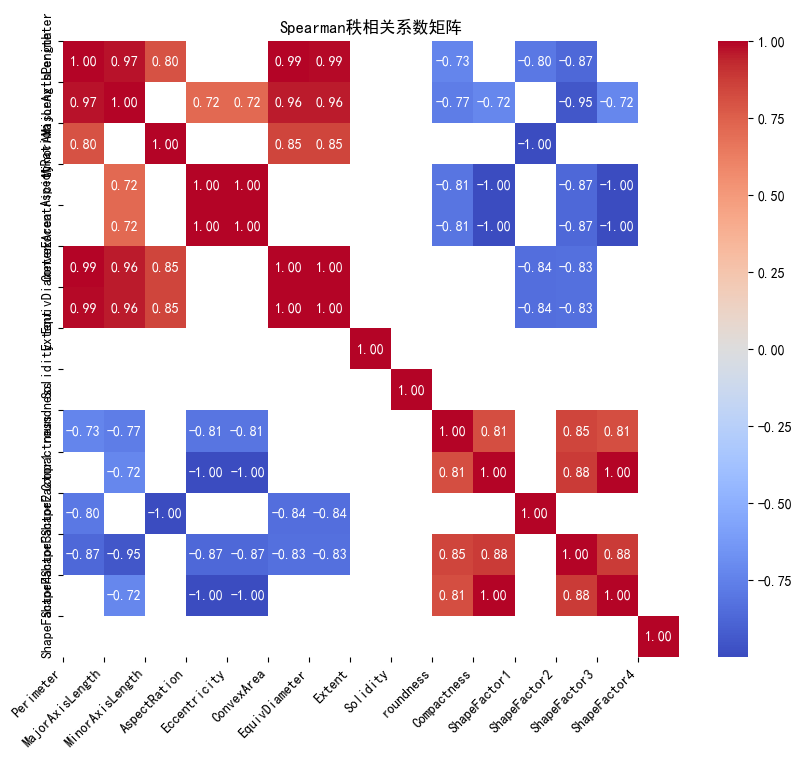

In [291]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
column_names = df.columns[1:-1].tolist()
feature_dict = {}
spearmanr_data = df.iloc[:,1:-1]
feature_dict = set_feature_dict(column_names,feature_dict)
value = 0.7
rela_class,feature_dict,feature_correlation_list = Feature_correlation_analysis_new(column_names,feature_dict,spearmanr_data,value)
target_variable = df['Class']
column_names = df.columns[1:-1]
feature_dict,target_variable_list = target_correlation_analysis(feature_dict,target_variable,column_names)

In [292]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.5
high_value = 0.7
rela = 0.25
value = 0.7
F_remove_com572570 = feature_selection_new2(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value,rela,value)
print(len(F_remove_com572570))
print(F_remove_com572570)

10
['Perimeter', 'ConvexArea', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [293]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove_com572570
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 5, 1)


In [294]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [295]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 18s 23ms/step - loss: 1.4580 - accuracy: 0.4495 - val_loss: 0.5033 - val_accuracy: 0.8544
Epoch 2/40
621/621 [==============================] - 13s 21ms/step - loss: 0.6440 - accuracy: 0.7863 - val_loss: 5.4986 - val_accuracy: 0.1468
Epoch 3/40
621/621 [==============================] - 13s 21ms/step - loss: 0.5707 - accuracy: 0.7949 - val_loss: 2.5103 - val_accuracy: 0.3621
Epoch 4/40
621/621 [==============================] - 13s 20ms/step - loss: 0.5305 - accuracy: 0.8137 - val_loss: 2.3683 - val_accuracy: 0.3422
Epoch 5/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4821 - accuracy: 0.8268 - val_loss: 0.4079 - val_accuracy: 0.8487
Epoch 6/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4364 - accuracy: 0.8459 - val_loss: 0.5074 - val_accuracy: 0.8209
Epoch 7/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4356 - accuracy: 0.8449 - val_loss: 1.5024 - val_accuracy:

In [296]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 7ms/step - loss: 0.3353 - accuracy: 0.8725
[0.3353279232978821, 0.8725075721740723]
              precision    recall  f1-score   support

           0    0.82942   0.71913   0.77035       737
           1    0.99854   1.00000   0.99927       686
           2    0.73640   0.85414   0.79091       713
           3    0.96510   0.75857   0.84946       729
           4    0.96598   0.92232   0.94364       708
           5    0.93268   0.96098   0.94662       692
           6    0.74824   0.90857   0.82065       700

    accuracy                        0.87251      4965
   macro avg    0.88234   0.87482   0.87441      4965
weighted avg    0.88177   0.87251   0.87292      4965



阈值25356075

D:\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


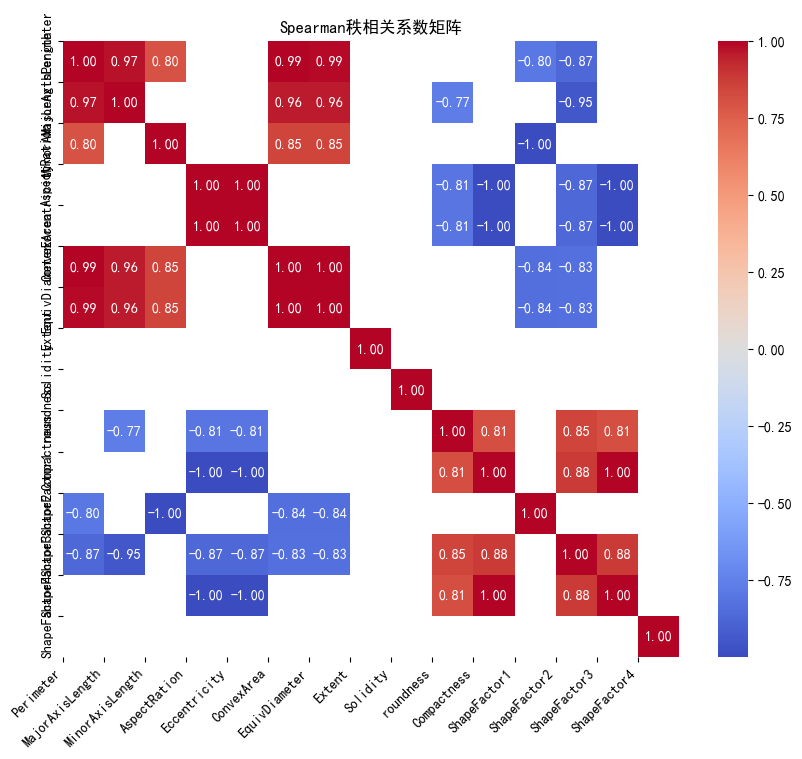

In [297]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
column_names = df.columns[1:-1].tolist()
feature_dict = {}
spearmanr_data = df.iloc[:,1:-1]
feature_dict = set_feature_dict(column_names,feature_dict)
value = 0.75
rela_class,feature_dict,feature_correlation_list = Feature_correlation_analysis_new(column_names,feature_dict,spearmanr_data,value)
target_variable = df['Class']
column_names = df.columns[1:-1]
feature_dict,target_variable_list = target_correlation_analysis(feature_dict,target_variable,column_names)

In [298]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.25
high_value = 0.35
rela = 0.60
value = 0.75
F_remove_com25356075 = feature_selection_new2(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value,rela,value)
print(len(F_remove_com25356075))
print(F_remove_com25356075)

9
['Perimeter', 'ConvexArea', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [299]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove_com25356075
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 6, 1)


In [300]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [301]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 18s 22ms/step - loss: 1.2609 - accuracy: 0.5570 - val_loss: 0.7600 - val_accuracy: 0.7291
Epoch 2/40
621/621 [==============================] - 13s 20ms/step - loss: 0.6331 - accuracy: 0.7863 - val_loss: 0.8010 - val_accuracy: 0.6977
Epoch 3/40
621/621 [==============================] - 13s 20ms/step - loss: 0.5638 - accuracy: 0.8043 - val_loss: 0.6711 - val_accuracy: 0.7633
Epoch 4/40
621/621 [==============================] - 13s 20ms/step - loss: 0.5182 - accuracy: 0.8221 - val_loss: 1.8660 - val_accuracy: 0.4512
Epoch 5/40
621/621 [==============================] - 13s 20ms/step - loss: 0.5452 - accuracy: 0.8091 - val_loss: 0.6848 - val_accuracy: 0.7235
Epoch 6/40
621/621 [==============================] - 13s 20ms/step - loss: 0.5072 - accuracy: 0.8224 - val_loss: 0.6683 - val_accuracy: 0.7519
Epoch 7/40
621/621 [==============================] - 13s 20ms/step - loss: 0.5017 - accuracy: 0.8184 - val_loss: 1.4070 - val_accuracy:

In [302]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 7ms/step - loss: 0.3177 - accuracy: 0.8775
[0.3177404999732971, 0.8775427937507629]
              precision    recall  f1-score   support

           0    0.84539   0.69742   0.76431       737
           1    0.99709   1.00000   0.99854       686
           2    0.73918   0.86255   0.79612       713
           3    0.94146   0.81619   0.87436       729
           4    0.95677   0.93785   0.94722       708
           5    0.92033   0.96821   0.94366       692
           6    0.78289   0.87571   0.82670       700

    accuracy                        0.87754      4965
   macro avg    0.88330   0.87971   0.87870      4965
weighted avg    0.88272   0.87754   0.87728      4965



阈值15556

D:\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


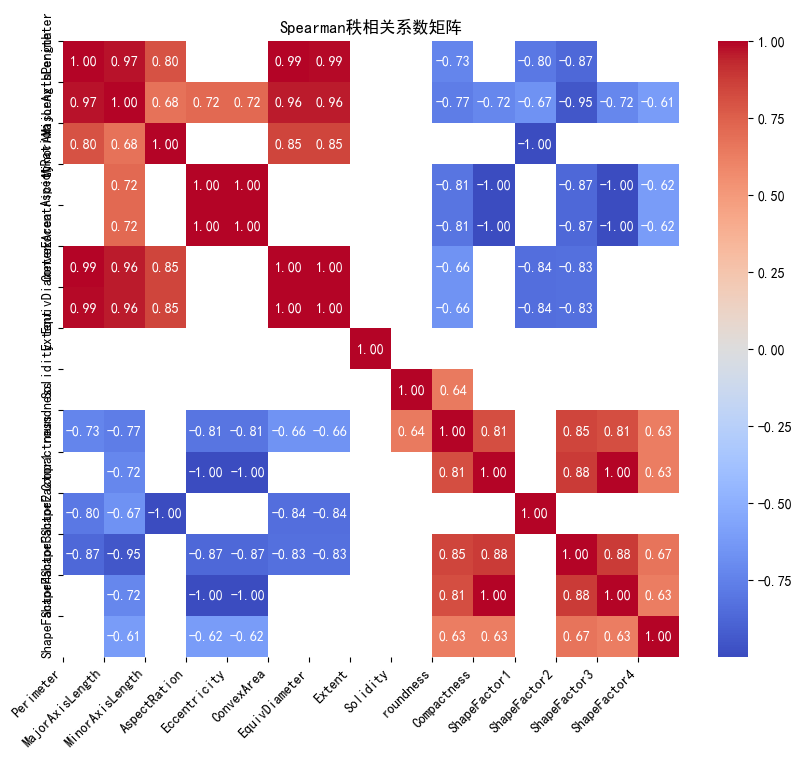

In [303]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
column_names = df.columns[1:-1].tolist()
feature_dict = {}
spearmanr_data = df.iloc[:,1:-1]
feature_dict = set_feature_dict(column_names,feature_dict)
value = 0.6
rela_class,feature_dict,feature_correlation_list = Feature_correlation_analysis_new(column_names,feature_dict,spearmanr_data,value)
target_variable = df['Class']
column_names = df.columns[1:-1]
feature_dict,target_variable_list = target_correlation_analysis(feature_dict,target_variable,column_names)

In [304]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.015
high_value = 0.55
rela = 0.55
value = 0.6
F_remove_com15556 = feature_selection_new2(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value,rela,value)
print(len(F_remove_com15556))
print(F_remove_com15556)

8
['Perimeter', 'ConvexArea', 'Solidity', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [305]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove_com15556
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 7, 1)


In [306]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [307]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 17s 22ms/step - loss: 1.3820 - accuracy: 0.5054 - val_loss: 0.4575 - val_accuracy: 0.8538
Epoch 2/40
621/621 [==============================] - 13s 20ms/step - loss: 0.5261 - accuracy: 0.8162 - val_loss: 0.3900 - val_accuracy: 0.8604
Epoch 3/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4816 - accuracy: 0.8261 - val_loss: 0.4100 - val_accuracy: 0.8431
Epoch 4/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4430 - accuracy: 0.8380 - val_loss: 0.4314 - val_accuracy: 0.8437
Epoch 5/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4362 - accuracy: 0.8410 - val_loss: 0.4359 - val_accuracy: 0.8324
Epoch 6/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4027 - accuracy: 0.8581 - val_loss: 0.3372 - val_accuracy: 0.8731
Epoch 7/40
621/621 [==============================] - 13s 21ms/step - loss: 0.3801 - accuracy: 0.8640 - val_loss: 0.3359 - val_accuracy:

In [308]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 7ms/step - loss: 0.3053 - accuracy: 0.8808
[0.3053387701511383, 0.8807653784751892]
              precision    recall  f1-score   support

           0    0.83096   0.71370   0.76788       737
           1    1.00000   1.00000   1.00000       686
           2    0.74784   0.84853   0.79501       713
           3    0.91292   0.86283   0.88717       729
           4    0.96755   0.92655   0.94661       708
           5    0.94798   0.94798   0.94798       692
           6    0.79049   0.87857   0.83221       700

    accuracy                        0.88077      4965
   macro avg    0.88539   0.88259   0.88241      4965
weighted avg    0.88449   0.88077   0.88102      4965



阈值175585

D:\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


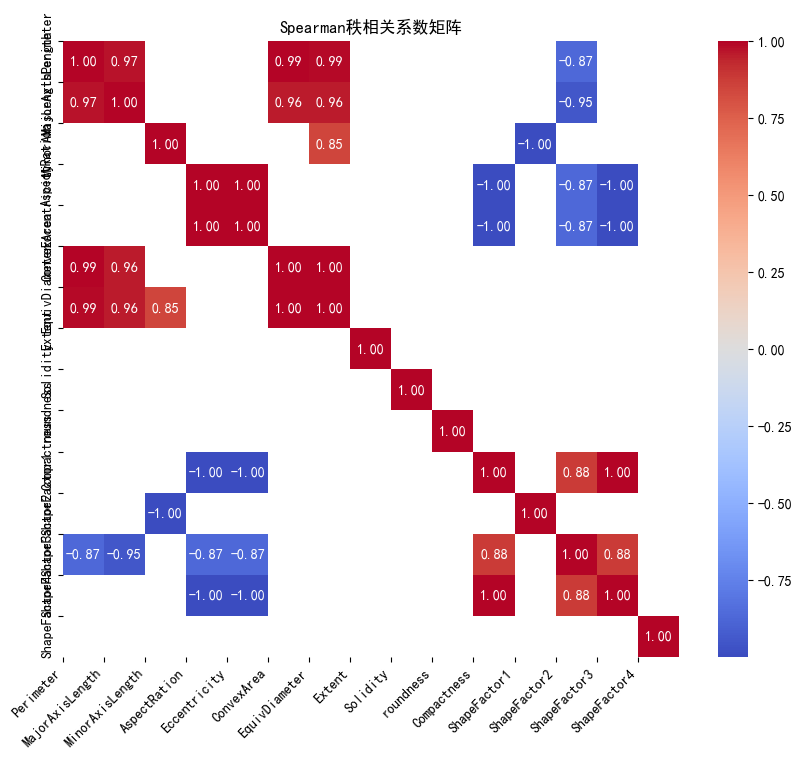

In [309]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
column_names = df.columns[1:-1].tolist()
feature_dict = {}
spearmanr_data = df.iloc[:,1:-1]
feature_dict = set_feature_dict(column_names,feature_dict)
value = 0.85
rela_class,feature_dict,feature_correlation_list = Feature_correlation_analysis_new(column_names,feature_dict,spearmanr_data,value)
target_variable = df['Class']
column_names = df.columns[1:-1]
feature_dict,target_variable_list = target_correlation_analysis(feature_dict,target_variable,column_names)

In [310]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.1
high_value = 0.7
rela = 0.55
value = 0.85
F_remove_com175585 = feature_selection_new2(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value,rela,value)
print(len(F_remove_com175585))
print(F_remove_com175585)

6
['Perimeter', 'ConvexArea', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [311]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove_com175585
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 9, 1)


In [312]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [313]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 18s 22ms/step - loss: 1.4519 - accuracy: 0.4743 - val_loss: 0.5270 - val_accuracy: 0.8264
Epoch 2/40
621/621 [==============================] - 13s 21ms/step - loss: 0.5317 - accuracy: 0.8181 - val_loss: 0.4102 - val_accuracy: 0.8514
Epoch 3/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4798 - accuracy: 0.8253 - val_loss: 0.3812 - val_accuracy: 0.8624
Epoch 4/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4477 - accuracy: 0.8356 - val_loss: 0.3529 - val_accuracy: 0.8691
Epoch 5/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4169 - accuracy: 0.8492 - val_loss: 0.3697 - val_accuracy: 0.8647
Epoch 6/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4328 - accuracy: 0.8376 - val_loss: 0.3730 - val_accuracy: 0.8570
Epoch 7/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4047 - accuracy: 0.8510 - val_loss: 0.3722 - val_accuracy:

In [314]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 7ms/step - loss: 0.2129 - accuracy: 0.9255
[0.2128632664680481, 0.9254783391952515]
              precision    recall  f1-score   support

           0    0.95182   0.88467   0.91702       737
           1    0.99854   1.00000   0.99927       686
           2    0.88235   0.94670   0.91340       713
           3    0.92669   0.86694   0.89582       729
           4    0.97325   0.92514   0.94859       708
           5    0.94978   0.95665   0.95320       692
           6    0.81572   0.90429   0.85772       700

    accuracy                        0.92548      4965
   macro avg    0.92831   0.92634   0.92643      4965
weighted avg    0.92820   0.92548   0.92594      4965



阈值56585

D:\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


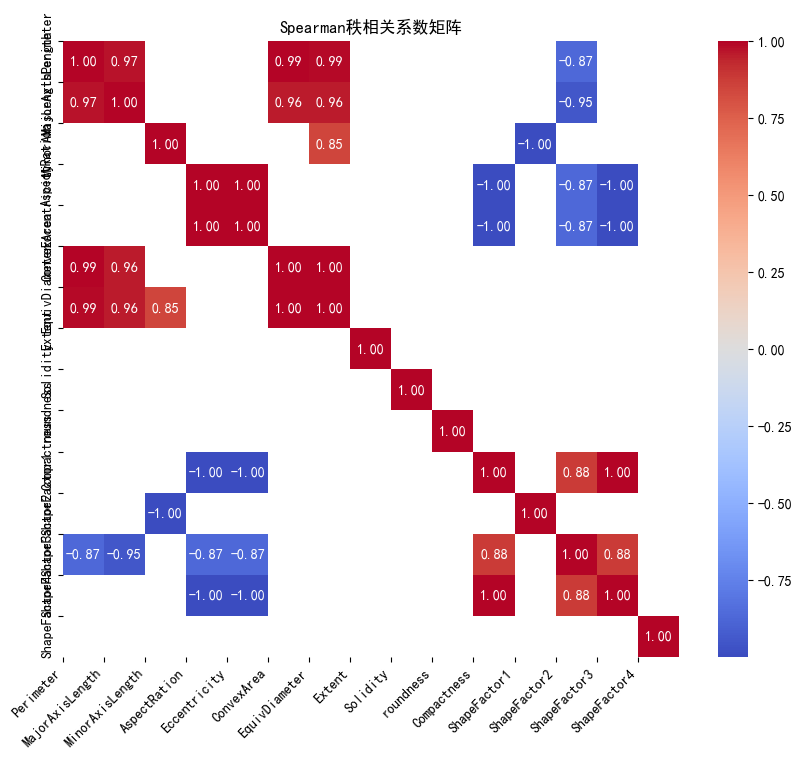

In [315]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
column_names = df.columns[1:-1].tolist()
feature_dict = {}
spearmanr_data = df.iloc[:,1:-1]
feature_dict = set_feature_dict(column_names,feature_dict)
value = 0.85
rela_class,feature_dict,feature_correlation_list = Feature_correlation_analysis_new(column_names,feature_dict,spearmanr_data,value)
target_variable = df['Class']
column_names = df.columns[1:-1]
feature_dict,target_variable_list = target_correlation_analysis(feature_dict,target_variable,column_names)

In [316]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.005
high_value = 0.65
rela = 0.65
value = 0.85
F_remove_com56585 = feature_selection_new2(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value,rela,value)
print(len(F_remove_com56585))
print(F_remove_com56585)

5
['Perimeter', 'ConvexArea', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3']


In [317]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove_com56585
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 10, 1)


In [318]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [319]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 19s 24ms/step - loss: 1.4151 - accuracy: 0.4797 - val_loss: 0.4759 - val_accuracy: 0.8363
Epoch 2/40
621/621 [==============================] - 13s 21ms/step - loss: 0.5475 - accuracy: 0.8161 - val_loss: 0.4426 - val_accuracy: 0.8326
Epoch 3/40
621/621 [==============================] - 13s 22ms/step - loss: 0.4533 - accuracy: 0.8382 - val_loss: 0.3557 - val_accuracy: 0.8753
Epoch 4/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4466 - accuracy: 0.8309 - val_loss: 0.4533 - val_accuracy: 0.8348
Epoch 5/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4255 - accuracy: 0.8493 - val_loss: 0.3571 - val_accuracy: 0.8687
Epoch 6/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4348 - accuracy: 0.8408 - val_loss: 0.3558 - val_accuracy: 0.8713
Epoch 7/40
621/621 [==============================] - 14s 22ms/step - loss: 0.3676 - accuracy: 0.8695 - val_loss: 0.3431 - val_accuracy:

In [320]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 8ms/step - loss: 0.2062 - accuracy: 0.9319
[0.20616978406906128, 0.9319234490394592]
              precision    recall  f1-score   support

           0    0.95894   0.88738   0.92178       737
           1    1.00000   1.00000   1.00000       686
           2    0.89774   0.94811   0.92224       713
           3    0.93997   0.88066   0.90935       729
           4    0.96243   0.94068   0.95143       708
           5    0.95129   0.95954   0.95540       692
           6    0.82879   0.91286   0.86880       700

    accuracy                        0.93192      4965
   macro avg    0.93417   0.93275   0.93271      4965
weighted avg    0.93412   0.93192   0.93227      4965



阈值15295

D:\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


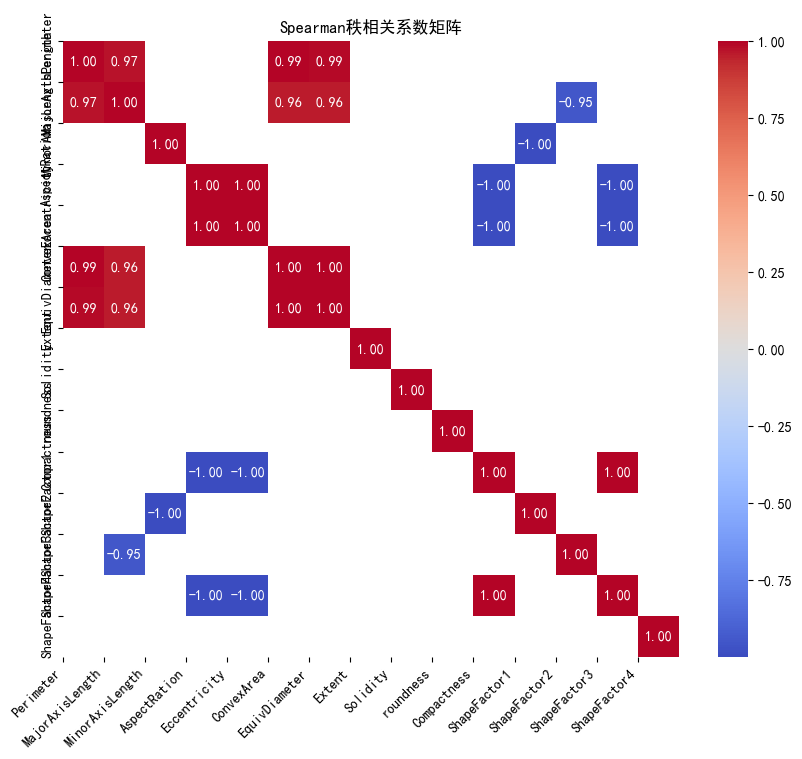

In [344]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
column_names = df.columns[1:-1].tolist()
feature_dict = {}
spearmanr_data = df.iloc[:,1:-1]
feature_dict = set_feature_dict(column_names,feature_dict)
value = 0.95
rela_class,feature_dict,feature_correlation_list = Feature_correlation_analysis_new(column_names,feature_dict,spearmanr_data,value)
target_variable = df['Class']
column_names = df.columns[1:-1]
feature_dict,target_variable_list = target_correlation_analysis(feature_dict,target_variable,column_names)

In [345]:
column_names = df.columns[1:-1].tolist()
column_names_test = column_names
feature_dict_test = feature_dict
rela_class_test = rela_class
max_values_test = max_values
low_value = 0.001
high_value = 0.5
rela = 0.2
value = 0.95
F_remove_com15295 = feature_selection_new2(column_names_test,feature_dict_test,rela_class_test,max_values_test,low_value,high_value,rela,value)
print(len(F_remove_com15295))
print(F_remove_com15295)

4
['ConvexArea', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3']


In [346]:
df = pd.read_csv("Dataset/test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove_com15295
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 11, 1)


In [347]:
inp=Input(shape=(x_train.shape[1:]))

x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.6)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.6)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.6)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.6)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.6)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.6)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [348]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

Epoch 1/40
621/621 [==============================] - 19s 24ms/step - loss: 1.5481 - accuracy: 0.4192 - val_loss: 0.5931 - val_accuracy: 0.8232
Epoch 2/40
621/621 [==============================] - 14s 23ms/step - loss: 0.5793 - accuracy: 0.7933 - val_loss: 0.6023 - val_accuracy: 0.7700
Epoch 3/40
621/621 [==============================] - 14s 22ms/step - loss: 0.5253 - accuracy: 0.8096 - val_loss: 0.4932 - val_accuracy: 0.8179
Epoch 4/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4742 - accuracy: 0.8252 - val_loss: 0.4244 - val_accuracy: 0.8425
Epoch 5/40
621/621 [==============================] - 14s 23ms/step - loss: 0.4428 - accuracy: 0.8416 - val_loss: 0.3249 - val_accuracy: 0.8953
Epoch 6/40
621/621 [==============================] - 14s 23ms/step - loss: 0.3622 - accuracy: 0.8771 - val_loss: 0.3013 - val_accuracy: 0.8981
Epoch 7/40
621/621 [==============================] - 14s 22ms/step - loss: 0.3569 - accuracy: 0.8796 - val_loss: 0.3068 - val_accuracy:

In [349]:
print(model.evaluate(x_test,y_test))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 8ms/step - loss: 0.2227 - accuracy: 0.9237
[0.22273874282836914, 0.9236656427383423]
              precision    recall  f1-score   support

           0    0.89453   0.93216   0.91296       737
           1    0.99854   1.00000   0.99927       686
           2    0.91000   0.89341   0.90163       713
           3    0.95349   0.84362   0.89520       729
           4    0.97474   0.92655   0.95004       708
           5    0.93539   0.96243   0.94872       692
           6    0.81923   0.91286   0.86351       700

    accuracy                        0.92367      4965
   macro avg    0.92656   0.92443   0.92447      4965
weighted avg    0.92630   0.92367   0.92395      4965

